In [126]:
from rdflib import Graph, Namespace, RDF, RDFS, XSD, Literal
from urllib.parse import quote
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from ctgan import synthesizers
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
import numpy as np
from scipy.stats import ttest_ind
from scipy import stats


In [12]:

ttl_file_path = 'C:/Users/Jesse/Thesis/OfficeGraph-main/airwits_devices_part1/airwits_devices_part1/C2E8A0.ttl'

# Create an RDF graph
g = Graph()

# Parse the TTL file and load its contents into the graph
g.parse(ttl_file_path, format='ttl')

<Graph identifier=Neb2e57d0b7c2403db3259822b4a27f8b (<class 'rdflib.graph.Graph'>)>

In [13]:
count = 0
# Iterate over each triple in the graph
for subj, pred, obj in g:
    if count < 5:
        print(subj,"   ",pred,"   ",obj)
        count += 1



https://interconnectproject.eu/example/measurement_R5_203__co2__12593     https://saref.etsi.org/core/relatesToProperty     https://interconnectproject.eu/example/property_R5_203__co2_
https://interconnectproject.eu/example/R5_203     https://saref.etsi.org/core/makesMeasurement     https://interconnectproject.eu/example/measurement_R5_203__co2__5755
https://interconnectproject.eu/example/measurement_R5_203__co2__4391     https://saref.etsi.org/core/hasTimestamp     2022-06-01T14:38:00
https://interconnectproject.eu/example/measurement_R5_203__co2__10115     https://saref.etsi.org/core/isMeasuredIn     http://www.wurvoc.org/vocabularies/om-1.8/partsPerMillion
https://interconnectproject.eu/example/R5_203     https://saref.etsi.org/core/makesMeasurement     https://interconnectproject.eu/example/measurement_R5_203__co2__6827


# From KG to PD table

In [14]:
triple_labels = {}
for triples in g:
        last_underscore_index = triples[0].rfind('_')
        label = triples[0][last_underscore_index + 1:]
        if label.isdigit():
                integer_label = int(label)
        
                if integer_label in triple_labels:
                # Append the triple to the list corresponding to the label
                        if triples[1] in "https://saref.etsi.org/core/hasTimestamp":
                                triple_labels[integer_label][0] = triples[2].toPython()
                        elif triples[1] in "https://saref.etsi.org/core/hasValue" and "co2" in triples[0]:
                                triple_labels[integer_label][1] = triples[2].toPython()
                        elif triples[1] in "https://saref.etsi.org/core/hasValue" and "temp" in triples[0]:
                                triple_labels[integer_label][2] = triples[2].toPython()
                        elif triples[1] in "https://saref.etsi.org/core/hasValue" and "humidity" in triples[0]:
                                triple_labels[integer_label][3] = triples[2].toPython()
                else:
                # Create a new list for the label and add the triple
                        triple_labels[integer_label] = [0,1,2,3]
                        if triples[1] in "https://saref.etsi.org/core/hasTimestamp":
                                triple_labels[integer_label][0] = triples[2].toPython()
                        elif triples[1] in "https://saref.etsi.org/core/hasValue" and "co2" in triples[0]:
                                triple_labels[integer_label][1] = triples[2].toPython()
                        elif triples[1] in "https://saref.etsi.org/core/hasValue" and "temp" in triples[0]:
                                triple_labels[integer_label][2] = triples[2].toPython()
                        elif triples[1] in "https://saref.etsi.org/core/hasValue" and "humidity" in triples[0]:
                                triple_labels[integer_label][3] = triples[2].toPython()

In [15]:
counter = 0
for label in sorted(triple_labels.keys()):
    if counter < 5:
        print(triple_labels[label])
        counter += 1

[datetime.datetime(2022, 3, 1, 0, 8), 453.0, 21.6, 26.0]
[datetime.datetime(2022, 3, 1, 0, 37), 464.0, 21.5, 27.0]
[datetime.datetime(2022, 3, 1, 1, 7), 480.0, 21.5, 27.0]
[datetime.datetime(2022, 3, 1, 1, 37), 460.0, 21.4, 27.0]
[datetime.datetime(2022, 3, 1, 2, 7), 491.0, 21.3, 27.0]


In [16]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_data = pd.DataFrame.from_dict(triple_labels)
df_data = df_data.T
df_data.columns = ["time", "co2_values", "temp_values", "humidity_values"]
df_data.sort_values(by=["time"]).tail()

,time,co2_values,temp_values,humidity_values
15949,2023-01-31 21:41:00,521.0,19.1,40.0
15950,2023-01-31 22:10:00,488.0,19.0,39.0
15951,2023-01-31 22:40:00,491.0,19.0,39.0
15952,2023-01-31 23:10:00,496.0,18.9,39.0
15953,2023-01-31 23:41:00,472.0,18.8,39.0


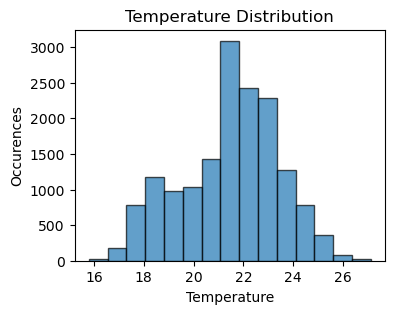

In [17]:
plt.figure(figsize=(4, 3))
plt.hist(df_data["temp_values"], bins=15, edgecolor='black', alpha=0.7)
plt.title("Temperature Distribution")
plt.xlabel("Temperature")
plt.ylabel("Occurences")
plt.show()

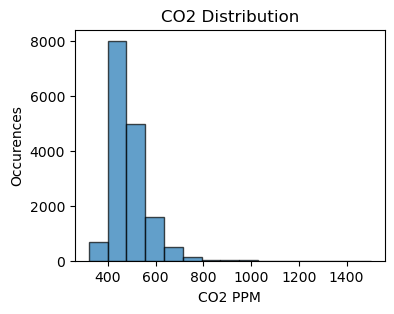

In [18]:
plt.figure(figsize=(4, 3)) 
plt.hist(df_data["co2_values"], bins=15, edgecolor='black', alpha=0.7)
plt.title("CO2 Distribution")
plt.xlabel("CO2 PPM")
plt.ylabel("Occurences")
plt.show()

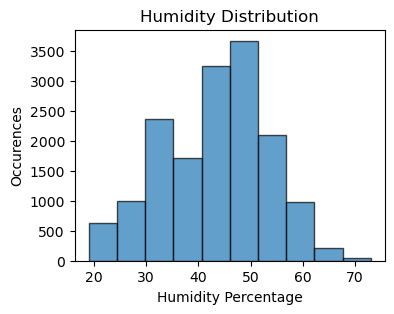

In [19]:
plt.figure(figsize=(4, 3)) 
plt.hist(df_data["humidity_values"], bins=10, edgecolor='black', alpha=0.7)
plt.title("Humidity Distribution")
plt.xlabel("Humidity Percentage")
plt.ylabel("Occurences")
plt.show()

In [20]:
df_data["co2_values"] = df_data["co2_values"].astype(float)
df_data["temp_values"] = df_data["temp_values"].astype(float)
df_data["humidity_values"] = df_data["humidity_values"].astype(float)

In [21]:
print(len(df_data))

15954


# Making a CTGAN model with the tabular data

In [22]:
"""metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_data)
metadata.update_column('time', datetime_format='%Y-%m-%d %H:%M:00')
model = CTGANSynthesizer(metadata,verbose=True, enforce_rounding=True, enforce_min_max_values=False, generator_lr=2e-3,epochs=1000)
model.fit(df_data)"""

"metadata = SingleTableMetadata()\nmetadata.detect_from_dataframe(df_data)\nmetadata.update_column('time', datetime_format='%Y-%m-%d %H:%M:00')\nmodel = CTGANSynthesizer(metadata,verbose=True, enforce_rounding=True, enforce_min_max_values=False, generator_lr=2e-3,epochs=1000)\nmodel.fit(df_data)"

In [128]:
model = CTGANSynthesizer.load("lr2e-3epoch1000.pkl")
synt_data = model.sample(15954)
synt_data["time"] = pd.to_datetime(synt_data["time"])
synt_data.sort_values(by=["time"])[200:205]

,time,co2_values,temp_values,humidity_values
7943,2022-03-05 17:58:00,452.0,22.4,23.0
4475,2022-03-05 19:03:00,486.0,21.5,30.0
4542,2022-03-05 19:52:00,420.0,21.4,33.0
12615,2022-03-05 20:14:00,517.0,22.1,19.0
5645,2022-03-05 20:45:00,538.0,21.4,23.0


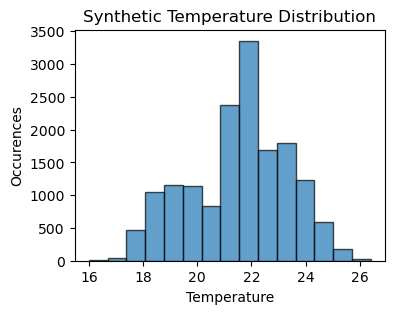

In [108]:
plt.figure(figsize=(4, 3))
plt.hist(synt_data["temp_values"], bins=15, edgecolor='black', alpha=0.7)
plt.title("Synthetic Temperature Distribution")
plt.xlabel("Temperature")
plt.ylabel("Occurences")
plt.show()

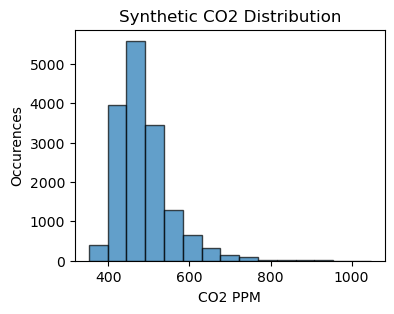

In [109]:
plt.figure(figsize=(4, 3)) 
plt.hist(synt_data["co2_values"], bins=15, edgecolor='black', alpha=0.7)
plt.title("Synthetic CO2 Distribution")
plt.xlabel("CO2 PPM")
plt.ylabel("Occurences")
plt.show()

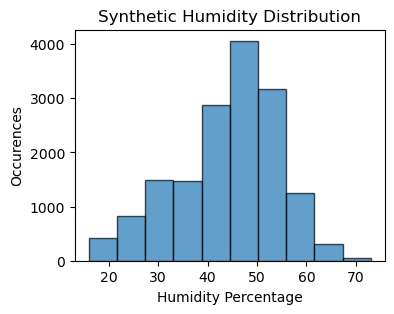

In [110]:
plt.figure(figsize=(4, 3)) 
plt.hist(synt_data["humidity_values"], bins=10, edgecolor='black', alpha=0.7)
plt.title("Synthetic Humidity Distribution")
plt.xlabel("Humidity Percentage")
plt.ylabel("Occurences")
plt.show()

# Getting synthetic data back into KG form

In [111]:
synt_graph = Graph()

ic = Namespace("https://interconnectproject.eu/example/")
saref = Namespace("https://saref.etsi.org/core/")
s4ener = Namespace("https://saref.etsi.org/saref4ener/")
s4bldg = Namespace("https://saref.etsi.org/saref4bldg/")
om = Namespace("http://www.wurvoc.org/vocabularies/om-1.8/")

synt_graph.bind("ic", "https://interconnectproject.eu/example/")
synt_graph.bind("saref", "https://saref.etsi.org/core/")
synt_graph.bind("s4ener", "https://saref.etsi.org/saref4ener/") #removed version number
synt_graph.bind("s4bldg", "https://saref.etsi.org/saref4bldg/") #removed version number
synt_graph.bind("om", "http://www.wurvoc.org/vocabularies/om-1.8/")

In [112]:
def MakeCO2Uri(row_number):
    return ic["measurement_R5_synt_co2_"+str(row_number)]
def MakeTempUri(row_number):
    return ic["measurement_R5_synt_temp_"+str(row_number)]
def MakeHumidityUri(row_number):
    return ic["measurement_R5_synt_humidity_"+str(row_number)]

In [113]:
synt_graph.add((ic.synt_R5, RDF.type, s4ener.Device))
synt_graph.add((ic.synt_R5, ic.hasDeviceType, Literal("Airwits", datatype=XSD.string)))
synt_graph.add((ic.synt_R5, ic.hasModel, Literal("R5", datatype=XSD.string)))
synt_graph.add((s4ener.Device, RDFS.subClassOf, saref.Device))
row_counter = 0

for index, row in synt_data.sort_values(by="time").iterrows():
    row_counter += 1
    co2_uri = MakeCO2Uri(row_counter)
    synt_graph.add((ic.synt_R5, saref.makesMeasurement, co2_uri))
    synt_graph.add((co2_uri, RDF.type, saref.Measurement))
    synt_graph.add((co2_uri, saref.hasTimestamp, Literal(row.iloc[0], datatype=XSD.dateTime)))
    synt_graph.add((co2_uri, saref.hasValue, Literal(row.iloc[1], datatype=XSD.float)))
    synt_graph.add((co2_uri, saref.isMeasuredIn, om.partsPerMillion))
    synt_graph.add((co2_uri, saref.relatesToProperty, ic.property_R5_synt_co2_))

    temp_uri = MakeTempUri(row_counter)
    synt_graph.add((ic.synt_R5, saref.makesMeasurement, temp_uri))
    synt_graph.add((temp_uri, RDF.type, saref.Measurement))
    synt_graph.add((temp_uri, saref.hasTimestamp, Literal(row.iloc[0], datatype=XSD.dateTime)))
    synt_graph.add((temp_uri, saref.hasValue, Literal(row.iloc[2], datatype=XSD.float)))
    synt_graph.add((temp_uri, saref.isMeasuredIn, om.degreeCelsius))
    synt_graph.add((temp_uri, saref.relatesToProperty, ic.property_R5_synt_temp_))

    humidity_uri = MakeHumidityUri(row_counter)
    synt_graph.add((ic.synt_R5, saref.makesMeasurement, humidity_uri))
    synt_graph.add((humidity_uri, RDF.type, saref.Measurement))
    synt_graph.add((humidity_uri, saref.hasTimestamp, Literal(row.iloc[0], datatype=XSD.dateTime)))
    synt_graph.add((humidity_uri, saref.hasValue, Literal(row.iloc[3], datatype=XSD.float)))
    synt_graph.add((humidity_uri, saref.isMeasuredIn, om.percent))
    synt_graph.add((humidity_uri, saref.relatesToProperty, ic.property_R5_synt_humidity_))

synt_graph.add((ic.property_R5_synt_co2_, RDF.type, ic.CO2Level))
synt_graph.add((ic.property_R5_synt_temp_, RDF.type, saref.Temperature))
synt_graph.add((ic.property_R5_synt_humidity_, RDF.type, saref.Humidity))

<Graph identifier=Nc25b7709d75f448f974924a7cb000056 (<class 'rdflib.graph.Graph'>)>

In [124]:
synt_graph.serialize("CTGAN_graph.ttl", format="ttl")

<Graph identifier=Nc25b7709d75f448f974924a7cb000056 (<class 'rdflib.graph.Graph'>)>

# Beginning of analysis

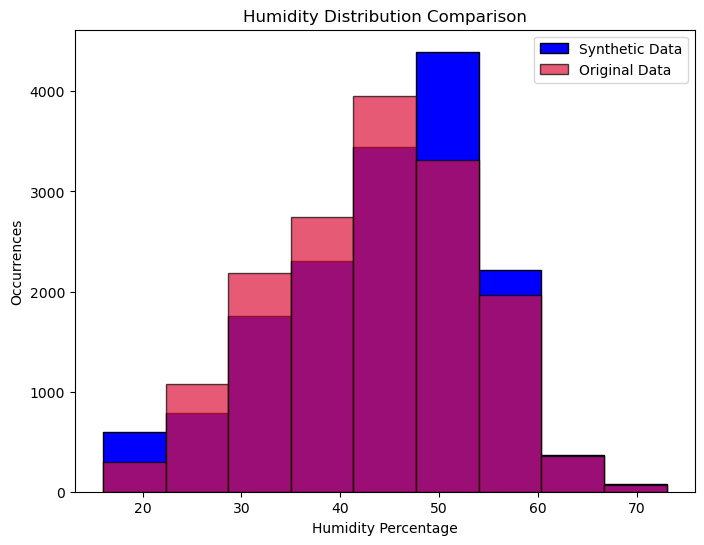

In [115]:
min_value = min(synt_data["humidity_values"].min(), df_data["humidity_values"].min())
max_value = max(synt_data["humidity_values"].max(), df_data["humidity_values"].max())
bins = np.linspace(min_value, max_value, 10)
plt.figure(figsize=(8, 6)) 
plt.hist(synt_data["humidity_values"], bins=bins, edgecolor='black', alpha=1, label='Synthetic Data', color='blue')
plt.hist(df_data["humidity_values"], bins=bins, edgecolor='black', alpha=0.7, label='Original Data', color='crimson')
plt.title("Humidity Distribution Comparison")
plt.xlabel("Humidity Percentage")
plt.ylabel("Occurrences")
plt.legend()
plt.show()

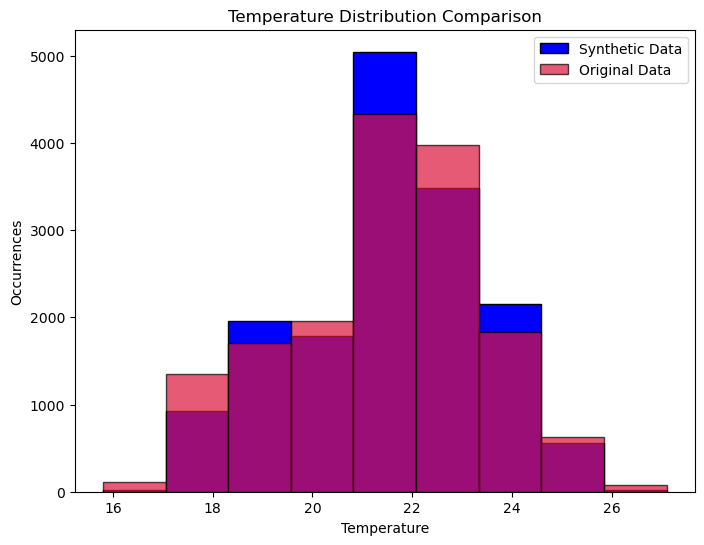

In [116]:
min_value = min(synt_data["temp_values"].min(), df_data["temp_values"].min())
max_value = max(synt_data["temp_values"].max(), df_data["temp_values"].max())
bins = np.linspace(min_value, max_value, 10)
plt.figure(figsize=(8, 6)) 
plt.hist(synt_data["temp_values"], bins=bins, edgecolor='black', alpha=1, label='Synthetic Data', color='blue')
plt.hist(df_data["temp_values"], bins=bins, edgecolor='black', alpha=0.7, label='Original Data', color='crimson')
plt.title("Temperature Distribution Comparison")
plt.xlabel("Temperature")
plt.ylabel("Occurrences")
plt.legend()
plt.show()

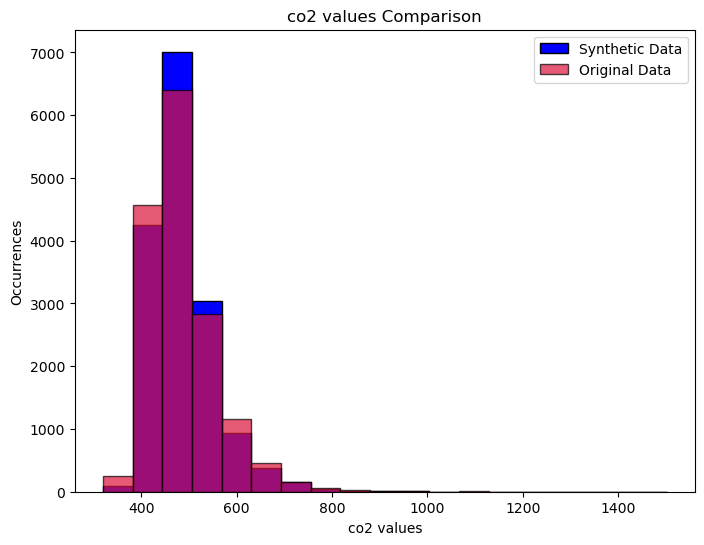

In [117]:
min_value = min(synt_data["co2_values"].min(), df_data["co2_values"].min())
max_value = max(synt_data["co2_values"].max(), df_data["co2_values"].max())
bins = np.linspace(min_value, max_value, 20)
plt.figure(figsize=(8, 6)) 
plt.hist(synt_data["co2_values"], bins=bins, edgecolor='black', alpha=1, label='Synthetic Data', color='blue')
plt.hist(df_data["co2_values"], bins=bins, edgecolor='black', alpha=0.7, label='Original Data', color='crimson')
plt.title("co2 values Comparison")
plt.xlabel("co2 values")
plt.ylabel("Occurrences")
plt.legend()
plt.show()

In [118]:
def euclidean_distance(feature):
    euclidian_distances = []
    previous_data = False
    for row in feature:
        current_data = row
        if previous_data:
            euclidian_distances.append(np.sqrt((current_data - old_data) ** 2))
        previous_data = True
        old_data = current_data
    return euclidian_distances

In [119]:
columns_to_test = [col for col in df_data.columns if col != "time"]
real_values = []
synt_values = []
for i in columns_to_test:
    real_distances = euclidean_distance(df_data.sort_values(by="time")[i])
    synt_distances = euclidean_distance(synt_data.sort_values(by="time")[i])
    real_values += [[np.mean(real_distances), np.std(real_distances, ddof=1)]]
    synt_values += [[np.mean(synt_distances), np.std(synt_distances, ddof=1)]]

In [120]:
print(real_values)
print(synt_values)

[[23.19494765874757, 20.022247707452998], [0.06574312041622266, 0.08107253990653862], [0.2649658371466182, 0.5505416662503038]]
[[67.60540337240644, 63.99511847755421], [1.387137215570739, 1.1611653412148548], [8.767441860465116, 7.001599300136675]]


In [121]:
t_test_results = []


for i in range(len(real_values)):
    t_test, p_value = stats.ttest_ind_from_stats(mean1=real_values[i][0], std1=real_values[i][1], nobs1=len(df_data["time"]),
                                                 mean2=synt_values[i][0], std2=synt_values[i][1], nobs2=len(synt_data["time"]))
    t_test_results.append((i, t_test, p_value))

for column, t_stat, p_value in t_test_results:
    print(f"Feature {column}: t-statistic = {t_stat:.2f}, p-value = {p_value:.3f}")


Feature 0: t-statistic = -83.66, p-value = 0.000
Feature 1: t-statistic = -143.39, p-value = 0.000
Feature 2: t-statistic = -152.91, p-value = 0.000


In [123]:
t_test_results2 = []
for i in columns_to_test:
    t_test, p_value = stats.ttest_ind_from_stats(mean1=np.mean(df_data[i]), std1=np.std(df_data[i]), nobs1=len(df_data["time"]),
                                                 mean2=np.mean(synt_data[i]), std2=np.std(synt_data[i]), nobs2=len(synt_data["time"]))
    t_test_results2.append((i, t_test, p_value))
    
for column, t_stat, p_value in t_test_results2:
    print(f"Feature {column}: t-statistic = {t_stat:.2f}, p-value = {p_value:.7f}")

Feature co2_values: t-statistic = 1.21, p-value = 0.2250029
Feature temp_values: t-statistic = -4.22, p-value = 0.0000241
Feature humidity_values: t-statistic = -8.82, p-value = 0.0000000
